In [1]:
%pylab inline

import cvxpy
from cvxpy import Variable, Minimize, sum_squares, pnorm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pickle
import gzip
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

sys.path.append('../../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *

from joblib import Parallel, delayed
import multiprocessing
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
def read_data(filename):

    # read the boundary points and get a mask
    raw_data = np.loadtxt(filename,skiprows=0)
    coords = raw_data[:,:2]
    deflection = raw_data[:,2]
    boundary = raw_data[:,3]
    return  coords, deflection, boundary


Populating the interactive namespace from numpy and matplotlib


In [2]:
pdata = pd.read_csv("./t2_generated.csv")


In [3]:
CUTOFF  = 12
N_SOLUTIONS = 64
gamma_vals = np.logspace(-4, -1, N_SOLUTIONS)



coords = np.array([pdata.x , pdata.y]).T
deflection_x = np.array(pdata.u_x)
deflection_y = np.array(pdata.u_y)
boundary = np.array(pdata.boundary)

x_obs_positions = sorted(set(coords[:, 0]))
y_obs_positions = sorted(set(coords[:, 1]))

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

boundary2d = boundary.reshape((N, M))
mask = np.zeros(boundary2d.shape)
for r in range(boundary2d.shape[1]):
    pts = np.where(boundary2d[:, r] == 1)
    
    if (len(pts[0]) > 0):
        mini = (min(min(pts)))
        maxi = max(max(pts))
        mask[ mini:maxi, r] = 1

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()

condition_inside = distances2d<=10
condition_outside = (distances2d>10) * (distances2d<=CUTOFF+10)

del distances2d, mask, boundary2d
gc.collect()



0

In [4]:
x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)

x_center = np.mean(x_in)
y_center = np.mean(y_in)

G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy,loworder = True)


Size of the problem is 5183


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


$$
\int_\Omega \vert \sigma \vert \mathrm{d}\mathbf{x} 
$$

In [5]:
results_3 = pickle.load(gzip.open('../results/isotropic_L1_synthetic_results_x_expanded.gz', 'rb'))
results_2 = pickle.load(gzip.open('../results/isotropic_L1_synthetic_results_expanded.gz', 'rb'))
results_1 = pickle.load(gzip.open('../results/anisotropic_L1_results.gz','rb'))
results = [results_1, results_2, results_3]
labels = [r"``truth''","both","x-only"]



In [6]:
def extractn(inlist,n):
    try:
        return inlist[n]
    except:
        return None

x_1 = results[0][-1][0]
y_1 = results[0][-1][1]
for rel in results: del(rel[-1])
x_min, x_max = 69.974999999999994, 133.72999999999999
y_min, y_max = 139.94999999999999, 189.71000000000001

best = [ 4, 43,39]


0
1
2


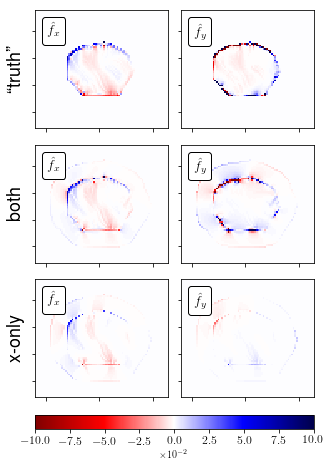

In [7]:
fig = plt.figure(figsize=(5,8))
#fig = plt.figure()
maxmagnitude = 10
gs0 = gridspec.GridSpec(3,1, hspace = 0.1,wspace=0.1)

gs_j = []
gs_j_innergrids = []
ax = []
im = []


for j in range(3):
    print(j)
    gs_j += [gridspec.GridSpecFromSubplotSpec(1,2,
                subplot_spec=gs0[j,0],
                  hspace = 0.1,wspace=0.1)]
                #height_ratios = [1,1,1,1,1,1,1])]
    
    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])

    try:
        s_x[condition_inside] = results[j][best[j]][0][0][:,0] * 1e2
        s_y[condition_inside] = results[j][best[j]][0][0][:,1] * 1e2
    except:
        s_x = results[j][best[j]][0][:,0] * 1e2
        s_y = results[j][best[j]][0][:,1] * 1e2
    # form a new 2x1 subplot of the results
    
    ax += [plt.Subplot(fig, gs_j[j][0,0])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 30, x_max + 30))
    ax[-1].set_ylim((y_min - 30, y_max + 30))
    #ax[-1].set_ylabel(labels[j],fontsize=18)
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    ax[-1].set_ylabel(labels[j],fontsize=18)

    #plt.axis('off')
    
    at = AnchoredText("$\hat{f}_{x}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

    z = np.ma.masked_array(s_x, np.abs(s_x) < 1e-6)    
    im += [ax[-1].pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude)]
    
    im[-1].axes.set_aspect('equal')
    
    ax += [plt.Subplot(fig, gs_j[j][0,1])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 30, x_max + 30))
    ax[-1].set_ylim((y_min - 30, y_max + 30))
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{f}_{y}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(s_y, np.abs(s_y) < 1e-6)        
    im += [ax[-1].pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude)]
    
    im[-1].axes.set_aspect('equal')
    
#ax[0].text(100,220,r"Unconstrained",fontsize=20)
#ax[2].text(120,220,r"Constrained",fontsize=20)

cb = fig.colorbar(im[0], ax = ax, fraction=0.06, pad=0.04, orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r"$\times 10^{-2}$")

plt.savefig("../../figures/fig11.pdf",bbox_inches='tight', 
               transparent=True,
               pad_inches=0.15, dpi=400)    